In [14]:
import os
import pandas as pd
import numpy as np
from math import inf

def map_to_weight_range(value, thresholds, weights):
    """
    Map a parameter value to a weight based on defined thresholds and weights.
    
    Parameters:
        value: The parameter value to be mapped.
        thresholds: List of threshold values defining the ranges.
        weights: List of weights corresponding to each range.
    
    Returns:
        The weight corresponding to the range in which the value falls.
    """
    for i in range(len(thresholds) - 1):
        if thresholds[i] <= value < thresholds[i + 1]:
            return weights[i]
    
    # If value doesn't fall within any defined range, return default weight
    return weights[-1]

def extract_weights_mapped(X, thresholds, weights):
    """
    Extract weights based on mapping parameter values to weight ranges.
    
    Parameters:
        X: Feature matrix (parameters).
        thresholds: List of threshold values defining the ranges for each parameter.
        weights: List of weights corresponding to each range for each parameter.
    
    Returns:
        Array of weights for each parameter based on mapping.
    """
    mapped_weights = []
    for i in range(X.shape[1]):  # Iterate over each parameter
        parameter_values = X[:, i]
        parameter_weights = [map_to_weight_range(value, thresholds[i], weights[i]) for value in parameter_values]
        mapped_weights.append(parameter_weights)
    
    return np.array(mapped_weights).T

# Define thresholds and weights for each parameter
asu_thresholds = [-inf, 0, 11, 21, 32, inf]  # Adjusted thresholds for ASU
asu_weights = [0, 0.25, 0.5, 0.75, 1]  # Corresponding weights for poor, fair, normal, good, and excellent

rsrp_thresholds = [-inf, -120, -110, -97, -87, -60, inf]  # Adjusted thresholds for RSRP
rsrp_weights = [0, 0.2, 0.4, 0.6, 0.8, 1]  # Corresponding weights for poor, fair, normal, good, and excellent

rsrq_thresholds = [-inf, -12, -10, -7, -5, inf]  # Adjusted thresholds for RSRQ
rsrq_weights = [0, 0.25, 0.5, 0.75, 1]  # Corresponding weights for poor, fair, normal, good, and excellent

speed_thresholds = [-inf, 30, 60, 90, 120, inf]  # Adjusted thresholds for speed (in whatever unit you're using)
speed_weights = [0, 0.25, 0.5, 0.75, 1]  # Corresponding weights for slow, moderate, fast, very fast, and super fast

# Combine thresholds and weights for all parameters
thresholds = [asu_thresholds, rsrp_thresholds, rsrq_thresholds, speed_thresholds]
weights = [asu_weights, rsrp_weights, rsrq_weights, speed_weights]

# Directory where CSV files are located
directory = "graphs"

# Iterate over CSV files in the directory
dfs = []
for root, dirs, files in os.walk(directory):
    for filename in files:
        if filename.endswith(".csv"):
            filepath = os.path.join(root, filename)
            # Read CSV file and keep only specified columns
            df = pd.read_csv(filepath, usecols=['  currentTime', ' longitude', ' latitude', ' speed', ' rsrq', ' rsrp', ' asu'])
            
            # Convert relevant columns to numeric, coerce non-numeric values to NaN
            df[[' speed', ' rsrq', ' rsrp', ' asu']] = df[[' speed', ' rsrq', ' rsrp', ' asu']].apply(pd.to_numeric, errors='coerce')
            
            # Extract fractional seconds from the time and convert to float
            df['time_diff'] = pd.to_datetime(df['  currentTime']).dt.strftime('%S.%f').astype(float)
            
            # Calculate time difference between consecutive rows
            df['time_diff'] = df['time_diff'].shift(-10) - df['time_diff']
            
            # Calculate speed variation (acceleration)
            df['speed_variation'] = (df[' speed'].shift(-8) - df[' speed']) / df['time_diff']
            
            dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Drop rows with NaN values
combined_df = combined_df.dropna()

# Add a new column 'signal_quality' based on the extracted weights
columns = [' asu', ' rsrp', ' rsrq', ' speed']  # Adjusted column names
X = combined_df[columns].values

# Calculate mean weighted signal quality across parameters and assign to 'signal_quality' column
combined_df['signal_quality'] = extract_weights_mapped(X, thresholds, weights).mean(axis=1)

# Display the combined DataFrame
print(combined_df)


                    currentTime   longitude   latitude     speed   asu   rsrq  \
0       2024-05-06 15:36:28.308    6.398430  35.893292  0.170282    45    -13   
1       2024-05-06 15:36:28.362    6.398430  35.893292  0.170282    45    -13   
2       2024-05-06 15:36:28.472    6.398430  35.893292  0.170282    45    -13   
3       2024-05-06 15:36:28.564    6.398432  35.893291  0.150372    45    -13   
4       2024-05-06 15:36:28.671    6.398432  35.893291  0.150372    45    -13   
...                         ...         ...        ...       ...   ...    ...   
41824   2024-03-21 22:04:13.873    6.397956  35.893647  4.612174    45    -13   
41825   2024-03-21 22:04:13.977    6.397956  35.893647  4.612174    45    -13   
41826    2024-03-21 22:04:14.07    6.397956  35.893647  4.612174    45    -13   
41827    2024-03-21 22:04:14.17    6.397956  35.893647  4.612174    45    -13   
41828   2024-03-21 22:04:14.276    6.397956  35.893647  4.612174    45    -13   

        rsrp  time_diff  sp

In [22]:
combined_df = combined_df[(combined_df[' rsrp'] >= -120) & (combined_df[' rsrp'] <= -60)]

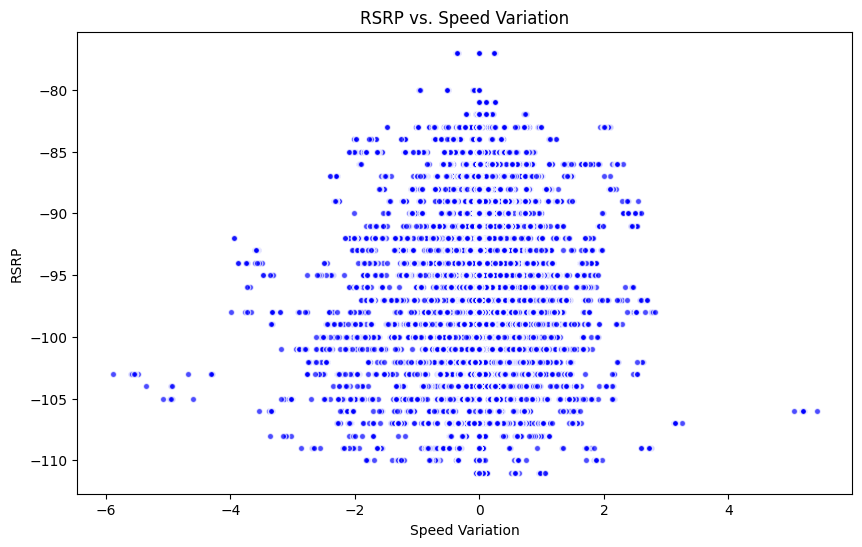

In [24]:
import matplotlib.pyplot as plt

# Scatter plot of signal quality vs. speed variation using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['speed_variation'], combined_df[' rsrp'], alpha=0.7, s=20, c='b', edgecolors='w')
plt.xlabel('Speed Variation')
plt.ylabel('RSRP')
plt.title('RSRP vs. Speed Variation')
plt.show()


In [26]:
# Calculate Pearson's correlation
pearson_corr = combined_df['speed_variation'].corr(combined_df[' rsrp'], method='pearson')
print("Pearson Correlation:", pearson_corr)

# Calculate Spearman's correlation
spearman_corr = combined_df['speed_variation'].corr(combined_df[' rsrp'], method='spearman')
print("Spearman Correlation:", spearman_corr)


Pearson Correlation: -0.0003583562582577477
Spearman Correlation: -0.11764036135726277


In [27]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data
X = combined_df['speed_variation'].values.reshape(-1, 1)
y = combined_df[' rsrp'].values

# Create a linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficient (slope) and intercept
slope = model.coef_[0]
intercept = model.intercept_

print("Linear Regression Coefficient (Slope):", slope)
print("Linear Regression Intercept:", intercept)


Linear Regression Coefficient (Slope): -0.0035547464383473538
Linear Regression Intercept: -93.80711065447808


In [28]:
combined_df = combined_df[(combined_df[' rsrq'] >= -18) & (combined_df[' rsrq'] <= -2)]

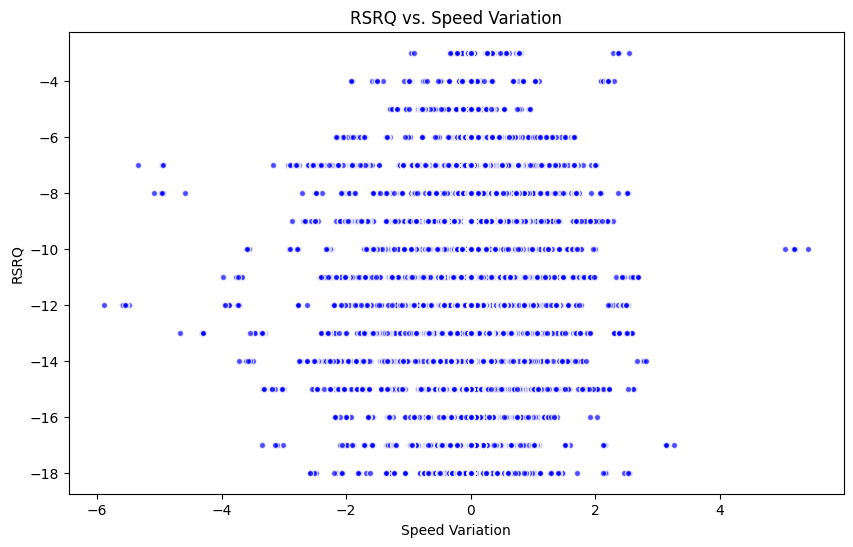

In [30]:
import matplotlib.pyplot as plt

# Scatter plot of signal quality vs. speed variation using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['speed_variation'], combined_df[' rsrq'], alpha=0.7, s=20, c='b', edgecolors='w')
plt.xlabel('Speed Variation')
plt.ylabel('RSRQ')
plt.title('RSRQ vs. Speed Variation')
plt.show()

In [32]:
# Calculate Pearson's correlation
pearson_corr = combined_df['speed_variation'].corr(combined_df[' rsrq'], method='pearson')
print("Pearson Correlation:", pearson_corr)

# Calculate Spearman's correlation
spearman_corr = combined_df['speed_variation'].corr(combined_df[' rsrq'], method='spearman')
print("Spearman Correlation:", spearman_corr)


Pearson Correlation: 0.0011438435391532091
Spearman Correlation: -0.04635708655897231


In [33]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data
X = combined_df['speed_variation'].values.reshape(-1, 1)
y = combined_df[' rsrq'].values

# Create a linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficient (slope) and intercept
slope = model.coef_[0]
intercept = model.intercept_

print("Linear Regression Coefficient (Slope):", slope)
print("Linear Regression Intercept:", intercept)


Linear Regression Coefficient (Slope): 0.006378052386133051
Linear Regression Intercept: -11.05062758576196


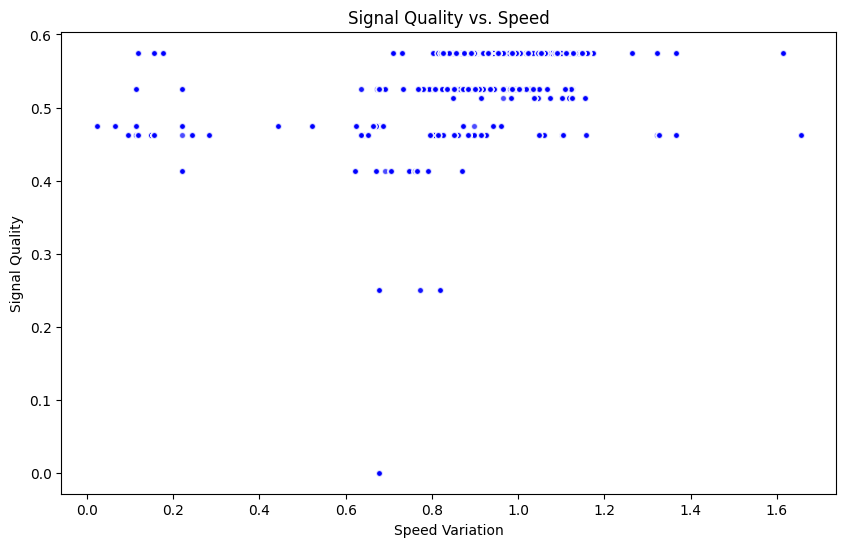

In [6]:
import matplotlib.pyplot as plt

# Scatter plot of signal quality vs. speed variation using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(combined_df[' speed'], combined_df['signal_quality'], alpha=0.7, s=20, c='b', edgecolors='w')
plt.xlabel('Speed Variation')
plt.ylabel('Signal Quality')
plt.title('Signal Quality vs. Speed')
plt.show()


In [85]:
# Calculate Pearson's correlation
pearson_corr = combined_df[' speed'].corr(combined_df['signal_quality'], method='pearson')
print("Pearson Correlation:", pearson_corr)

# Calculate Spearman's correlation
spearman_corr = combined_df[' speed'].corr(combined_df['signal_quality'], method='spearman')
print("Spearman Correlation:", spearman_corr)

Pearson Correlation: 0.13304864833453434
Spearman Correlation: 0.07395362873387712


In [90]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data
X = combined_df[' speed'].values.reshape(-1, 1)
y = combined_df['signal_quality'].values

# Create a linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficient (slope) and intercept
slope = model.coef_[0]
intercept = model.intercept_

print("Linear Regression Coefficient (Slope):", slope)
print("Linear Regression Intercept:", intercept)




Linear Regression Coefficient (Slope): 0.004850071825854048
Linear Regression Intercept: 0.3591986079007472
